## Experiments
This script recreates the plots and tables of the experimental evaluation in the paper.
By default it assumes that the data is stored in the directory:
- `experimental_results/simulation_collection/` for the Finite Horizon setting and 
- `experimental_results/simulation_collection_period/` for the Periodic setting.

To reproduce all plots, simply run: `reproduce_experiments()`.

In [5]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import itertools, os
import matplotlib.patches as patches
import random
import seaborn as sns
import tqdm
import scipy as sci
from scipy.stats import binom
import itertools
%matplotlib inline
from matplotlib.axes._axes import Axes
from matplotlib.markers import MarkerStyle
from seaborn import color_palette
from numpy import ndarray


In [6]:


class DataSet:
    
    def __init__(self, period=1, name=None, og_data=None, setting=None, data=None, base_path=None):
        self.METRICS = ['dp',"acc_cost","acc_util", "n_interventions"]
        if base_path is not None:
            self.base_path = base_path
        elif period==1:
            self.base_path =  "experimental_results/simulation_collection/"
        else:
            self.base_path =  "experimental_results/simulation_collection_period/"
        self.base_parameter = ["fairness", "dataset","sensitive_attr","ml_algo","time_horizon",
                               "cost_type","n_cost_bin",
                           "threshold","lambda_decision", "composition_type", "periods"]
        self.base_types = {"fairness": str, "dataset": str, "sensitive_attr": str, "ml_algo": str,
                           "time_horizon": int, "cost_type": str, "n_cost_bin": int,
                           "threshold": self.thresh, "lambda_decision": float, "composition_type": str, 
                           "periods": int}
        
        
        self.colmap = {"fair_val": "Bias", "shield":"Shield", "step":"Step", "value_type":"Aggregation Method",
                 "fairness":"Fairness Property", "ml_algo":"ML Algorithm", "acc_cost":"Accumulated Cost",
                      "diff_util":"Utility Loss", "environment":"Environment", "threshold":"Threshold",
                      "ass_viol": "Assumption Violated", "fair_viol":"Fairness Violation", "period":"Period"} 
        self.shieldmap = {"none":"No Shield", "naive":"Static-Fair", 
                     "bounded_acc_rates":"Static-BW","buffered":"Dynamic" }
        self.fairmap = {"dp":"DP", "eo":"EqOpp"}
        self.mlmap = {"diffdp":"DiffDP", "erm":"ERM", "hsic":"HSIC", "laftr":"LAFTR", "pr":"PRemover"}

        self.name = name
        self.data_set = self.data_sets(name)
        self.og_data = og_data
        self.setting = setting
        if data is None and setting is not None and og_data is not None:
            self.data = self.post_process()
        else:
            self.data = data
        self.period=period
        
    def rename_data(self, data= None):
        if data is None:
            data = self.data.copy()
        data["shield"] = data["shield"].apply(lambda x : self.shieldmap[x])
        data["fairness"] = data["fairness"].apply(lambda x : self.fairmap[x])
        data["ml_algo"] = data["ml_algo"].apply(lambda x : self.mlmap[x])
        data = data.rename(columns=self.colmap)
        return data
        
    def true_name(self, col):
        return self.colmap[col]
    
        
    def get_single_data(self, data=None):
        if data is not None:
            self.single_data = data[data["periods"]==1]
            return self.single_data.copy()
        elif self.data is not None:
            self.single_data = self.data[self.data["periods"]==1]
            return self.single_data.copy()
        else:
            return None
        return None

    def process_comp_name(self, file_name):
        name = file_name.split("_composable_")
        name1 = self.process_single_name(name[0])
        name2 = name[1].replace(".csv", "")
        name2 = name2.rsplit("_", 1)
       
        fin_name = [self.base_types[self.base_parameter[i]](v) for i, v in enumerate(name1 + name2)]
        return fin_name

    def process_single_name(self, file_name):
        name = file_name.split("_")
        name[-1] = name[-1].replace(".csv", "")
        if name[0]!="eo":
            name = ["dp"] + name
        if name[1] == "bank":
            name = [name[0]] + name[1:2] + name[3:]
        return name

    def data_sets(self, name):
        if name is None:
            return {"path":  self.base_path.format(),
                      "parameter": self.base_parameter,
                      "parse_foo": self.process_comp_name}
    
    def thresh(self, val):
        return float(val)/10000
    
    def load_setting(self):
        if self.setting is None:
            file_dir = self.data_set["path"]
            param_names = self.data_set["parameter"]
            parse_name_foo = self.data_set["parse_foo"]
            file_names = os.listdir(file_dir)
            all_dfs = []
            run_id = 0
            setting_id = 0
            data = [parse_name_foo(file_name) for file_name in file_names if ".csv" in file_name]
            df = pd.DataFrame(data, columns=param_names)
            combs = list(itertools.product(*[list(df[c].unique()) for c in df.columns]))
            df = pd.DataFrame(combs, columns=param_names).reset_index().rename(
                columns={"index": "setting_id","dp": "fair_val"})
            df["shield"] = df["composition_type"]
            df.loc[df["sensitive_attr"]=="sex", "sensitive_attr"] = "gender"
            df["environment"] = df["dataset"] + ", " + df["sensitive_attr"]
            self.setting = df
            
        return self.setting.copy()
       
    def clean_data(self, df):
        fair = df["fairness"].unique()[0]
        for g in ["A","B"]:
            for k in ["seen", "acc"]:
                if fair=="eo":
                    df[f"g{g}{k}1"] = df[f"g{g}{k}"]
                    df[f"g{g}{k}"] = df[f"g{g}{k}0"] + df[f"g{g}{k}1"]
                if fair=="dp":
                    for n in ["0","1"]:
                        df[f"g{g}{k}{n}"] = np.NaN            
        return df

    def load_data(self):
        if self.og_data is None:
            file_dir = self.data_set["path"]
            param_names = self.data_set["parameter"]
            parse_name_foo = self.data_set["parse_foo"]
            file_names = os.listdir(file_dir)
            all_dfs = []
            run_id = 0
            for file_name in tqdm.tqdm(file_names):
                if ".csv" in file_name:
                    name = parse_name_foo(file_name)
                    file_path = os.path.join(file_dir, file_name)
                    tmp_df = pd.read_csv(file_path, index_col=0)
                    #tmp_df["setting_name"] = ", ".join(name)
                    tmp_df["run_id"] = tmp_df["sim_num"] + run_id
                    for i, v in enumerate(param_names):
                        tmp_df[v] = name[i]
                    if tmp_df["periods"].unique() == self.period:
                        run_id = tmp_df["run_id"].max() + 1
                        temp_df = self.clean_data(tmp_df)
                        temp_df = temp_df.rename(columns={"dp": "fair_val"})
                        all_dfs.append(tmp_df)
            df = pd.concat(all_dfs, ignore_index=True)
            self.og_data = df
        return self.og_data.copy()

    def post_process(self):
        parameter_names = self.data_set["parameter"]
        df_og = self.og_data
        df_og["ml_util"] = (1-df_og["intervention"])*df_og["utility"] + df_og["intervention"]*(1-df_og["utility"])
        df_og['acc_ml_util'] = df_og.groupby('run_id')["ml_util"].cumsum()
        df_og["diff_util"] = df_og["acc_util"]/df_og["acc_ml_util"]
        df_og.loc[df_og["sensitive_attr"]=="sex", "sensitive_attr"] = "gender"
        df_og = df_og[(df_og["lambda_decision"].isin([0,1]))]
        dfs = []
        for fair in df_og["fairness"].unique():
            base_df = df_og[(df_og["fairness"]==fair) & (df_og["composition_type"]=="none")].copy()
            for dpt in df_og["threshold"].unique():
                for cost in df_og["cost_type"].unique():
                    bdf = base_df.copy()
                    bdf["fairness"] = fair
                    bdf["threshold"] = dpt
                    bdf["cost_type"] = cost
                    dfs.append(bdf)
        df = pd.concat([df_og[df_og["composition_type"]!="none"].copy()] + dfs, ignore_index=True)
        df = pd.merge(df, self.setting, on=parameter_names, how='left')
        df = df.rename(columns={"dp": "fair_val"})
        df.loc[df["sensitive_attr"]=="sex", "sensitive_attr"] = "gender"
        self.setting.loc[self.setting["sensitive_attr"]=="sex", "sensitive_attr"] = "gender"
        df["period"] = (df["step"])// (df["time_horizon"])
        df = df[(df["ml_algo"]!="adv") & (df["lambda_decision"].isin([0,1]))]
        self.data= df
        return self.data.copy()
    
    def process_data(self, save_memory=False):
        setting = self.load_setting()
        og_data = self.load_data()
        data = self.post_process()
        self.check_data()
        if save_memory:
            self.og_data = None
            return data, setting
        else:
            return data, setting, og_data
        
    def check_data(self):
        dic = {}
        inp_df = self.data.copy()
        for v, df in inp_df.groupby("fairness"):
            max_sim= df["sim_num"].max()+1
            max_step = df["step"].max() +1
            r = df[df["step"]==0].groupby("setting_id").size().reset_index()
            r = r[r[0]!=max_sim]
            r2 = df.groupby(["setting_id", "run_id"]).size().reset_index()
            r2 = r2[r2[0]!=max_step]
            dic[v] = [r,r2]
        return dic
    
    def comp_diff_util(self, data):
        data["diff_util"] = (data["acc_ml_util"]-data["acc_util"])/data["acc_ml_util"]*100
        return data
    
    def basic_filter(self, data):
        return  data[data["cost_type"]=="constant"].copy()
    
    def single_clean(self, agg=0, drop_none=False):
        bdf = self.data.copy()
        bdf = self.comp_diff_util(bdf)
        bdf = self.basic_filter(bdf)
        if agg == 1: 
            bdf = self.condition_on_last(bdf)
        if agg==0:
            bdf = self.condition_on_last(bdf)
            bdf = bdf.groupby("setting_id")[["diff_util", "fair_val"]].mean().reset_index()
            bdf = bdf.merge(self.setting, on=["setting_id"], how="left")
        if drop_none:
            bdf = bdf[(bdf["shield"]=="naive")]
        return bdf.copy()
    
    def multi_clean(self, agg=0, filt=True, filt_ass=False):
        kpi = ["ass_viol","fair_viol","diff_util"]
        bdf = self.data.copy()
        bdf = self.comp_diff_util(bdf)
        bdf = self.basic_filter(bdf)
        if filt:
            bdf = bdf[(bdf["shield"]!="none") & (bdf["ml_algo"]=="erm")]
        else:
            bdf = bdf[(bdf["ml_algo"]=="erm")]
        if filt_ass:
             bdf = bdf[(bdf["ass_viol"]==0)]
        
        bdf = bdf[bdf["cost_type"]=="constant"]
        pdf = bdf.groupby(["setting_id","run_id","period"]).tail(1).copy()
        pdf["fair_sat"] = (pdf["fair_val"] > pdf["threshold"]).astype(int)
        pdf = pdf.apply(self.naive_assumption, axis=1)
        res1 = pdf.groupby(["setting_id",
                           "run_id"])[["failure", "fair_sat"]].max().reset_index().rename(
            columns={"failure":"ass_viol", "fair_sat":"fair_viol"})
        res2 = bdf.groupby(["setting_id", "run_id", "period"])[["utility", "ml_util"]].sum().rename(
            columns={"utility":"p_util", "ml_util":"p_ml_util"})
        ndf = bdf.merge(res2, on=["setting_id", "run_id", "period"], how="left")
        ndf = ndf.merge(res1, on=["setting_id", "run_id"], how="left")
        if agg==3:
            return ndf
        elif agg==2:
            return ndf.groupby(["setting_id", "run_id","period"]).tail(1)
        elif agg==1:
            return ndf.groupby(["setting_id", "run_id"]).tail(1)
        else: 
            #pdf = pdf.merge(res, on=["setting_id", "run_id"], how="left")
            ndf = ndf.groupby(["setting_id", "run_id"]).tail(1)
            #kpi = ["ass_viol","fair_viol","diff_util"]
            res = ndf.groupby("setting_id")[kpi].mean().reset_index()
            return res.merge(self.setting, on="setting_id", how="left")
    
    
    def get_clean_data(self, agg=0, drop_none=False, filt_ass=False):
        if self.period==1:
            return self.single_clean(agg, drop_none)
        else:
            return self.multi_clean(agg, filt=drop_none, filt_ass=filt_ass)
            
    
    def condition_on_last(self, data=None):
        if data is None:
            return self.data.groupby(["setting_id","run_id"]).tail(1).copy()
        return data.groupby(["setting_id","run_id"]).tail(1).copy()
    
    def naive_assumption(self, x):
        if x["shield"]=="naive":
            if x["fairness"] == "dp":
                x["failure"] = int(x["gAseen"]!=x["gBseen"])
            elif x["fairness"] == "eo":
                x["failure"] = int(x["gAseen1"]!=x["gBseen1"])
        return x


In [35]:
class Analyse:
    
    def __init__(self, base_path=None, data_single=None, data_multi=None):
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.serif'] = ['Times New Roman']
        if base_path is None:
            self.base_path = "experimental_results/graphs/paper"
        else:
            self.base_path =  base_path
           
        os.makedirs(self.base_path, exist_ok=True)
        self.data_single = data_single
        self.data_multi = data_multi
        
        
    def load_data(self):
        if self.data_single is None:
            self.data_single = DataSet(period=1)
            self.data_single.process_data()
        if self.data_multi is None:
            self.data_multi = DataSet(period=10)
            self.data_multi.process_data()
        
    def process_single(self):
        if self.data_single is None:
            self.data_single = DataSet(period=1)
            self.data_single.process_data()
        self.single_cost_util()
        self.single_fairness_value_distribution()
        self.single_comp_conditional_utility_box()
        self.single_comp_conditional_utility_kde()
        
    def process_multi(self):
        if self.data_multi is None:
            self.data_multi = DataSet(period=10)
            self.data_multi.process_data()
        self.multi_fail_rates()
        self.multi_period_cost_decrease()
        self.multi_fairness_value_distribution_box(False)
        self.multi_fairness_value_distribution_box(True)
        self.multi_papter_temp_both()
        
            
    def process_both(self):
        self.process_single()
        self.process_multi()
        self.both_heat_comp()
        

    
    def process_paper(self):
        if self.data_single is None:
            self.data_single = DataSet(period=1)
            self.data_single.process_data()
        if self.data_multi is None:
            self.data_multi = DataSet(period=10)
            self.data_multi.process_data()
        self.both_heat_comp()
        self.multi_papter_temp_both()
        self.multi_fail_rates()
        
        
    def single_heat_comparison_data(self):
        #bdf = single_clean(df)
        bdf = self.data_single.get_clean_data(agg=0, drop_none=True)
        data = {}
        for g in bdf.groupby(["threshold"]):
            thr = g[0]
            for i, gs in enumerate(g[1].groupby("fairness")):
                fair = gs[0]
                pdf = gs[1]
                data[thr,fair]= pdf.pivot(index="environment", columns="ml_algo", values="diff_util").sort_index()
        return data
    
    
    ### Plot Fig. 4
    def single_cost_util(self):
        bdf = self.data_single.get_clean_data(agg=1, drop_none=True)
        bdf = bdf[bdf["shield"]!="none"]
        bdf = self.data_single.rename_data(bdf)
        rn = self.data_single.true_name
        sns.lmplot( data=bdf, x=rn("acc_cost"),  y=rn("diff_util"), hue=rn("environment"), row=rn("threshold"), col=rn("fairness"),
                   scatter_kws={'alpha':0.1, "s":5}, facet_kws={'sharey': False, 'sharex': False}, aspect=1.2)
        plt.savefig(os.path.join(self.base_path, "single_corr_cost_util.pdf"),
                        bbox_inches='tight', pad_inches=0.1)
   
    # Plot Fig 5 and 6
    def single_comp_conditional_utility_box(self):
        bdf = self.data_single.get_clean_data(agg=1, drop_none=True)
        pdf = self.data_single.rename_data(bdf)
        rn = self.data_single.true_name
        sns.catplot(kind="boxen",data=pdf, y=rn("diff_util"),   x=rn("threshold") ,hue=rn("ml_algo"), col=rn("fairness"),
                   sharey=False, sharex=False, showfliers=False) 
        plt.savefig(os.path.join(self.base_path, f"single_utilit_distr_mlalgo_box.pdf"),  bbox_inches='tight', pad_inches=0.1)
        sns.catplot(kind="boxen",data=pdf, y=rn("diff_util"),   x=rn("threshold") ,hue=rn("environment"), col=rn("fairness"),
                   sharey=False, sharex=False, showfliers=False) 
        plt.savefig(os.path.join(self.base_path, f"single_utilit_distr_enviornment_box.pdf"),  bbox_inches='tight', pad_inches=0.1)
        
        
    # Plot Fig. 7
    def single_fairness_value_distribution(self):
        bdf = self.data_single.get_clean_data(agg=1, drop_none=False)
        bdf["Normalised Fairness"] = bdf["fair_val"] / bdf["threshold"]
        bdf["Violated"] = bdf["Normalised Fairness"] > 1
        #bdf = bdf[bdf["shield"]=="none"]
        pbdf = self.data_single.rename_data(bdf)
        rn = self.data_single.true_name
        g = sns.displot(kind="hist", data=pbdf, x="Normalised Fairness",hue=rn("fairness"), col=rn("shield"), 
                        facet_kws={'sharey': False, 'sharex': False},
                        element="step", stat="percent", binwidth=0.1)
        shield = ["naive", "none"]
        fair = {"dp":"blue", "eo":"orange"}
        for i, ax in enumerate(g.axes.flat):
            for fa, cfa in fair.items():
                meanf = bdf[(bdf["fairness"]==fa) & (bdf["shield"]==shield[i])]["Normalised Fairness"].mean()
                ax.axvline(x=meanf, color=cfa, linestyle='--')
            if i==0:
                ax.set_ylim(0,10)
                ax.set_xlim(0,2)
            ax.axvline(x=1, color='red', linestyle='--')
        plt.savefig(os.path.join(self.base_path,"violation_distr.pdf"),
                        bbox_inches='tight', pad_inches=0.1)
        latex_df = pbdf.round(2).groupby([rn("fairness"),rn("shield")])["Normalised Fairness"].agg(
                QL25=lambda x: x.quantile(0.25),
                Median=lambda x: x.quantile(0.5),
                QL75=lambda x: x.quantile(0.75),
                Mean=lambda x: x.mean(),
                Std=lambda x: x.std(),
                Above=lambda x: (len(x[x>1])/len(x))*100)
        print(latex_df.style.format(precision=2).to_latex())
        return bdf
        
    def multi_heat_comp_data(self, filt=True):
        bdf = self.data_multi.get_clean_data(agg=0, drop_none=True, filt_ass=filt)
        col = bdf["shield"].unique()
        data = {}
        for g in bdf.groupby(["threshold"]):
            thr = g[0]
            for i, gs in enumerate(g[1].groupby("fairness")):
                fair = gs[0]  
                pdf = gs[1]
                pdf = pdf.pivot(index="environment", columns="shield", values="diff_util").sort_index()
                add_col = set(col).difference(pdf.columns)
                for c in add_col:
                    pdf[c] = np.nan
                pdf = pdf[sorted(pdf.columns)]
                data[thr, fair] = pdf
        return data

    # Plot Tab. 2,3,4
    def both_heat_comp(self):
        data = {"FinHzn":self.single_heat_comparison_data(),
                "Periodic": self.multi_heat_comp_data(False),
               # "Periodic Cond.": multi_heat_comp_data(df2, True)
               }

        col = {"dp":sns.light_palette("seagreen", as_cmap=True),
               "eo":sns.light_palette("#69d", as_cmap=True)}
        thresh = set(self.data_single.data["threshold"].unique()).intersection(self.data_multi.data["threshold"].unique())
        xorder = {"Periodic":[self.data_multi.shieldmap[i] for i in ["naive","bounded_acc_rates","buffered"]], 
                 "FinHzn":[self.data_single.mlmap[i] for i in ["diffdp", "erm", "hsic", "laftr", "pr"]],
                 #"Periodic Cond.":["Static-Fair","Static-BW","Dynamic"]
                 }

        xmap = {"Periodic":self.data_multi.shieldmap, 
                 #"Periodic Cond.":{"naive":"Static-Fair","bounded_acc_rates":"Static-BW","buffered":"Dynamic"},
                 "FinHzn":self.data_single.mlmap }
        
        for tr in thresh:
            fig, axs = plt.subplots(2, len(data), figsize=(15, 5), gridspec_kw={'wspace': 0.05})
            for i,(fair,c) in enumerate(col.items()):
                for j, (kind, dat) in enumerate(data.items()):
                    ax = axs[i,j]
                    pdf = data[kind][tr, fair]
                    #pdf.index = [f"${v}$" for v in pdf.index]
                    pdf = pdf.rename(columns=xmap[kind])
                    pdf = pdf[xorder[kind]]
                    sns.heatmap(pdf, annot=True, cmap=c, ax=ax, cbar=False, fmt=".2f")
                    if i==0:
                        ax.set_title(kind)
                        #ax.xaxis.set_label_position("top")
                        #ax.set_xlabel(k, labelpad=10) 
                    if j !=0:
                        ax.set_yticks([])
                    if i != 1:
                        ax.set_xticks([])
                    ax.set_ylabel("")
                    ax.set_xlabel("")
                    if i ==1:
                        if kind=="FinHzn":
                            ax.set_xlabel(self.data_single.true_name("ml_algo"))
                        else:
                            ax.set_xlabel(self.data_multi.true_name("shield"))
            plt.savefig(os.path.join(self.base_path,f"heat_util_thr-{tr}.pdf"),
                        bbox_inches='tight', pad_inches=0.1)

    # Generate Tab. 2
    def multi_fail_rates(self):
        bdf = self.data_multi.get_clean_data(agg=1)
        bdf = self.data_multi.rename_data(bdf)
        rn = self.data_multi.true_name
        bdf["Fairness Satisfied"] = 1-bdf[rn("fair_viol")]
        bdf["Assumption Satisfied"] = 1-bdf[rn("ass_viol")]
        rn = self.data_multi.true_name
        fdf = bdf.groupby([rn("fairness"), rn("shield")])["Assumption Satisfied", "Fairness Satisfied"].mean()
        #fdf["Conditional"] = bdf[bdf["ass_viol"]==1].groupby(["fairness", "shield"])["fair_sat"].mean()
        #for t in [0.1, 0.2]:
        #    fdf[f"ass_viol {t}"] = bdf[bdf["threshold"]==t].groupby(["fairness", "shield"])["ass_viol"].mean().values
        
        print(fdf.apply(self.to_percent).style.to_latex())
        return fdf
    
    # Plot Fig 8
    def multi_period_cost_decrease(self, filt=True):
        bdf = self.data_multi.get_clean_data(agg=2, drop_none=True)
        kpi = ["ass_viol","fair_viol","diff_util"]
        bdf["abs_util_loss"]= bdf["p_ml_util"]-bdf["p_util"]
        res = bdf.groupby(["setting_id", "run_id"]
                         )["abs_util_loss"].sum().reset_index().rename(columns={"abs_util_loss":"total_util_loss" })
        bdf = bdf.merge(res, on=["setting_id", "run_id"], how="left")
        bdf["Percentage Utility Loss"] = bdf["abs_util_loss"] / bdf["total_util_loss"]*100
        if filt:
            bdf = bdf[(bdf["ass_viol"]==0)]
        pdf = self.data_multi.rename_data(bdf)
        rn = self.data_multi.true_name
        sns.catplot(kind="boxen", data=pdf, hue=rn("period"), y="Percentage Utility Loss", x=rn("shield"), 
                    col=rn("fairness"), row=rn("threshold"),sharey=False,showfliers=False , aspect=1.2,
                    order=self.get_shield_order(),
                   col_order=[self.data_multi.fairmap["dp"], self.data_multi.fairmap["eo"]])
        plt.savefig(os.path.join(self.base_path,f"multi_period_cost_decrease_cond-{filt}.pdf"),
                        bbox_inches='tight', pad_inches=0.1)
        return pdf
       
    # Plot Fig 2
    def multi_papter_temp_both(self):
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.serif'] = ['Times New Roman']
        plt.rcParams['font.size'] = 20
        df2 = self.data_multi.data.copy()
        fdf = df2[(df2["dataset"]=="adult") & 
                  (df2["threshold"]==0.1) &  (df2["sensitive_attr"]=="gender") ]
        bdf1 = self.process_temp_data(fdf)
        bdf1 = bdf1[bdf1["value_type"]!="min"]
        periods = fdf["periods"].unique()[0]
        period_len = fdf["time_horizon"].unique()[0]


        pdf1 = self.data_multi.rename_data(bdf1)
        rn = self.data_multi.true_name
        custom_palette = sns.color_palette("muted", 6)  # Create a palette with 3 colors
        custom_palette.pop(3)

        g =sns.relplot(kind="line", data=pdf1,  y=rn("fair_val"), x=rn("step"), hue=rn("shield"), 
                        style=rn("value_type"), col=rn("fairness"), 
                        hue_order= [self.data_multi.shieldmap[c] for c in ["naive", "bounded_acc_rates", "buffered","none"]] , 
                        dashes=[(2, 0),(1, 1)], palette=custom_palette,
                        estimator=None, aspect=1.5)
        for ax in g.axes.flat:
            ax.axhline(y=0.1, color='red', linestyle='--')

            for i in range(1,periods):
                ax.axvline(x=i*period_len, color='#D3D3D3', linestyle=":")
            #ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

            ax.set_ylim(0,0.45)
        plt.text(-665, 0.03, rn("threshold"), color='red', rotation=90)
        plt.savefig(os.path.join(self.base_path, f"tempplot3.pdf"), bbox_inches='tight', pad_inches=0.1)
    
    def process_temp_data(self, df):
        bdf2 = df.copy()
        bdf2 = bdf2.groupby(["step","setting_id"]).agg({ m :['mean', 'min', 'max'] for m in ["fair_val"]})
        bdf2 = bdf2.stack().reset_index()
        bdf2 = pd.merge(bdf2, self.data_multi.setting, on=["setting_id"], how='left')
        names = [i for i in list(bdf2.columns) if "level_" in i]     
        bdf2 = bdf2.rename(columns={names[0]: "value_type"})
        return bdf2

    def to_percent(self, x):
        return "$"+ (100*x).round(2).astype(str) + "$"
    
    def get_shield_order(self, with_none=False):
        order = ["naive", "bounded_acc_rates", "buffered"]
        if with_none:
            order += ["none"]
        return [self.data_multi.shieldmap[x] for x in order]

    # Plot Fig 9 and 10
    def multi_fairness_value_distribution_box(self, filt=False):
        bdf = self.data_multi.get_clean_data(agg=2, drop_none=False)
        if filt:
            bdf = bdf[(bdf["ass_viol"]==0)]
        bdf["Normalised Fairness"] = bdf["fair_val"] / bdf["threshold"]
        bdf["Violated"] = bdf["Normalised Fairness"] > 1
        pdf = self.data_multi.rename_data(bdf)
        rn = self.data_multi.true_name
        g = sns.catplot(kind="boxen", data=pdf,  y="Normalised Fairness" , aspect=1.2
                        ,x =rn("shield"), hue=rn("period"), col=rn("fairness"),log_scale=True, 
                        order=self.get_shield_order(True),
                       col_order=[self.data_multi.fairmap["dp"], self.data_multi.fairmap["eo"]])
        for ax in g.axes.flat:
            ax.axhline(y=1, color='red', linestyle='--')
        plt.savefig(os.path.join(self.base_path, f"multi_violation_distr_box_cond-{filt}.pdf"),  bbox_inches='tight', pad_inches=0.1)

    # Plot Fig 7 and 8 but the true distribution. 
    def single_comp_conditional_utility_kde(self):
        bdf = self.data_single.get_clean_data(agg=1, drop_none=False)
        pdf = self.data_single.rename_data(bdf)
        rn = self.data_single.true_name
        sns.displot(kind="kde",data=pdf, x=rn("diff_util"),   hue=rn("ml_algo") ,row=rn("threshold"),col=rn("fairness"), 
                    facet_kws={'sharey': False, 'sharex': False}, aspect=1.2) 
        plt.savefig(os.path.join(self.base_path, f"single_utilit_distr_mlalgo_kde.pdf"),  bbox_inches='tight', pad_inches=0.1)
        sns.displot(kind="kde",data=pdf, x=rn("diff_util"),   hue=rn("environment") ,
                    row=rn("threshold"),col=rn("fairness"), facet_kws={'sharey': False, 'sharex': False}, aspect=1.2) 
        plt.savefig(os.path.join(self.base_path, f"single_utilit_distr_enviornment_kde.pdf"),  bbox_inches='tight', pad_inches=0.1)
        

          

In [36]:
def reproduce_experiments():
    ana = Analyse()
    ana.load_data()
    ana.process_both()
    
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:01<00:00, 72.44it/s]


\begin{tabular}{llrrrrrr}
 &  & QL25 & Median & QL75 & Mean & Std & Above \\
Fairness Property & Shield &  &  &  &  &  &  \\
\multirow[c]{2}{*}{DP} & No Shield & 0.38 & 0.83 & 1.59 & 1.22 & 1.29 & 42.46 \\
 & Static-Fair & 0.18 & 0.42 & 0.74 & 0.46 & 0.31 & 0.00 \\
\multirow[c]{2}{*}{EqOpp} & No Shield & 0.67 & 1.76 & 3.62 & 2.76 & 3.01 & 65.06 \\
 & Static-Fair & 0.00 & 0.21 & 0.50 & 0.27 & 0.28 & 0.00 \\
\end{tabular}



/var/folders/6p/1fp413rd6lj5pt9t3m1g09z40000gn/T/ipykernel_22309/3188503094.py:206: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  fdf = bdf.groupby([rn("fairness"), rn("shield")])["Assumption Satisfied", "Fairness Satisfied"].mean()


\begin{tabular}{llll}
 &  & Assumption Satisfied & Fairness Satisfied \\
Fairness Property & Shield &  &  \\
\multirow[c]{4}{*}{DP} & Dynamic & $100.0$ & $100.0$ \\
 & No Shield & $100.0$ & $23.57$ \\
 & Static-BW & $43.81$ & $83.1$ \\
 & Static-Fair & $0.0$ & $95.71$ \\
\multirow[c]{4}{*}{EqOpp} & Dynamic & $49.76$ & $100.0$ \\
 & No Shield & $100.0$ & $22.14$ \\
 & Static-BW & $4.05$ & $56.43$ \\
 & Static-Fair & $0.0$ & $100.0$ \\
\end{tabular}



/Users/krk/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/krk/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4575: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/krk/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/krk/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4575: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/krk/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4575: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/var/folders/6p/1fp413rd6lj5pt9t3m1g09z40000gn/T/ipykernel_

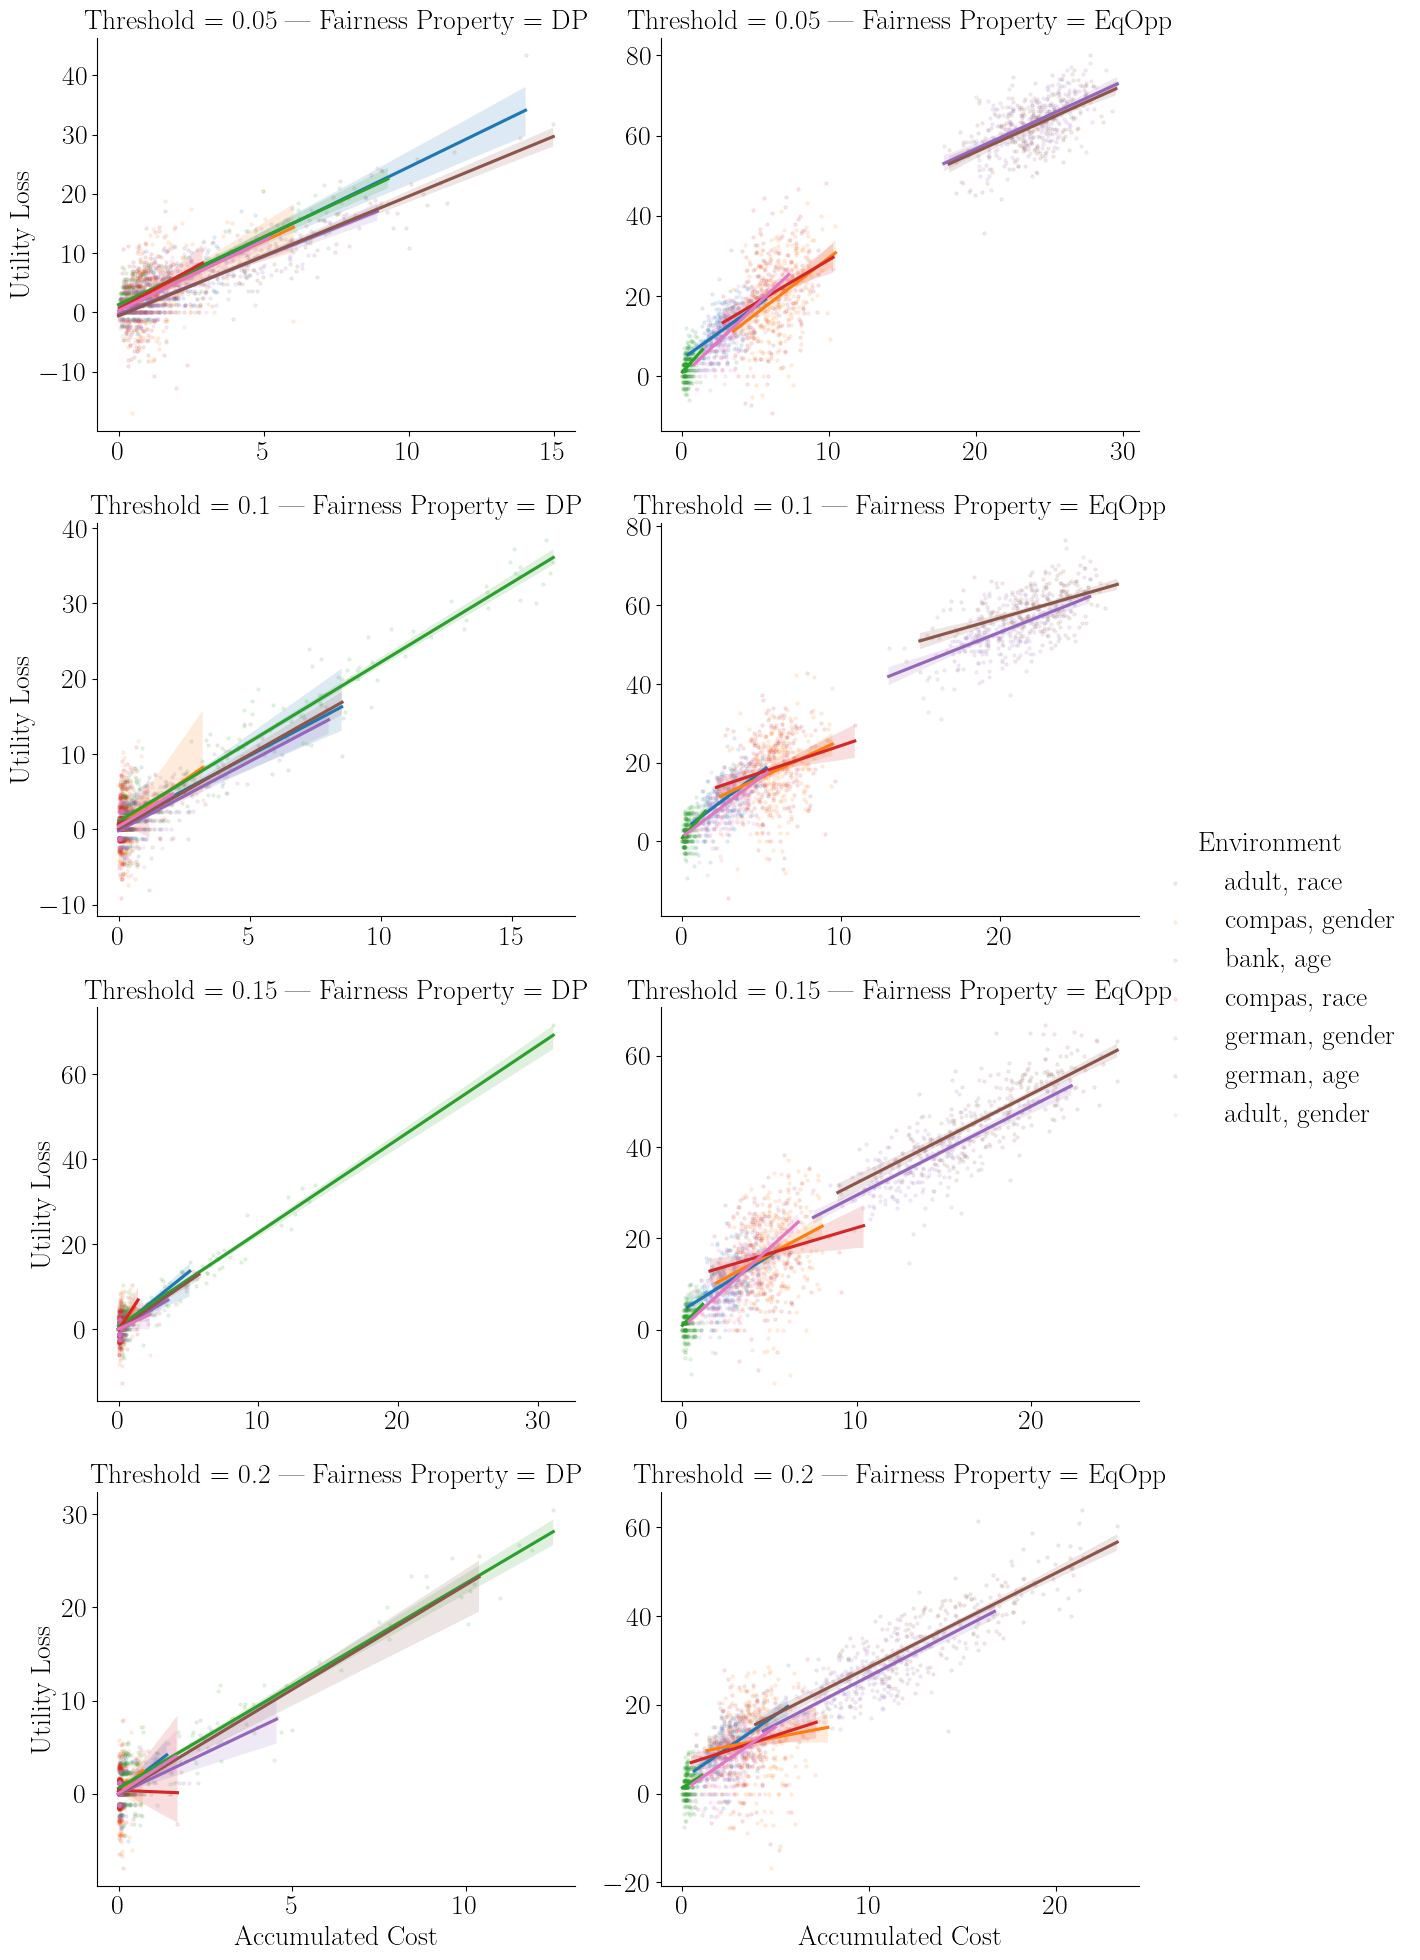

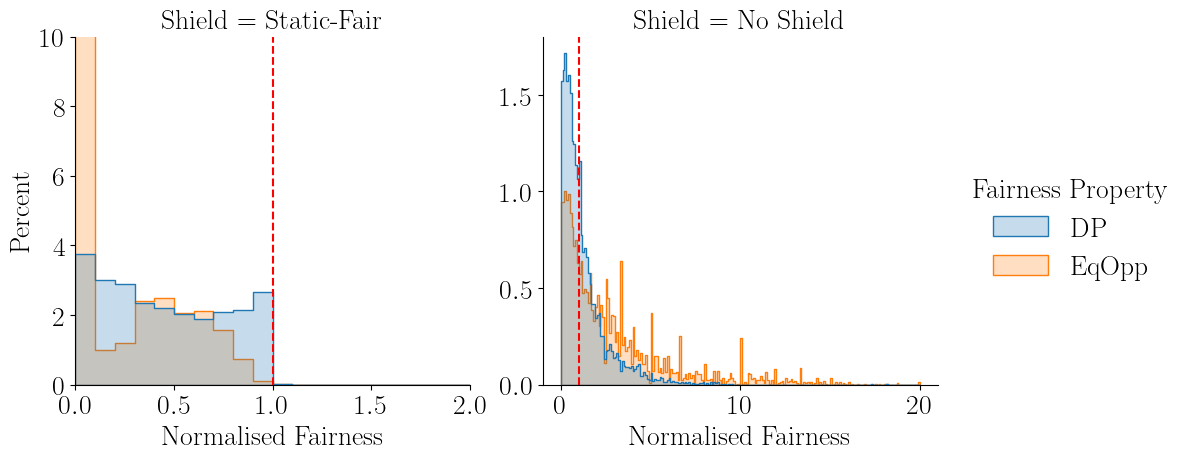

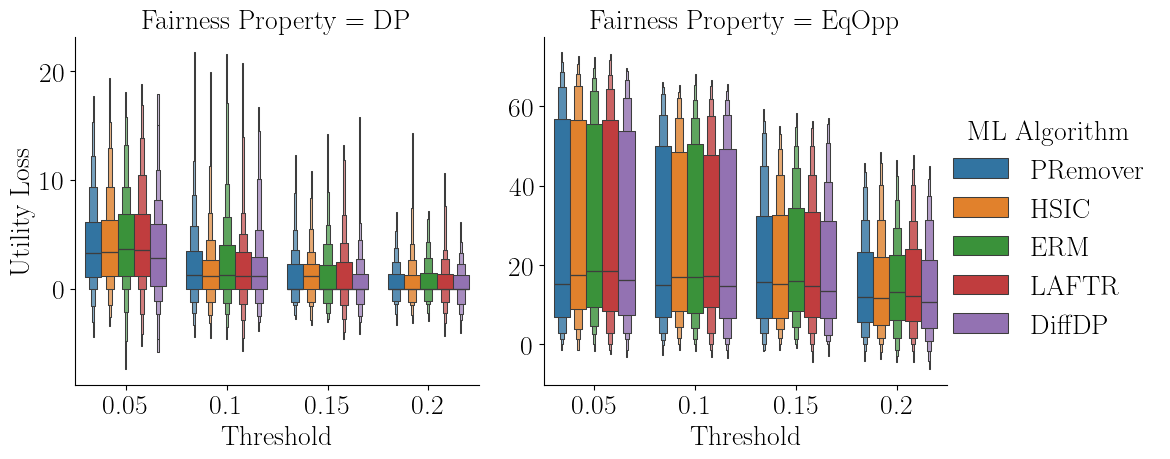

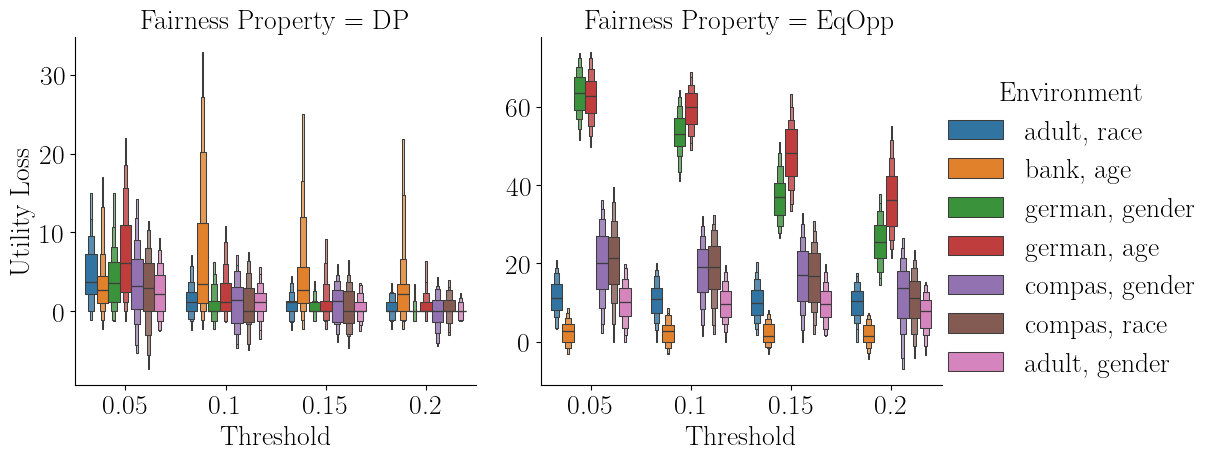

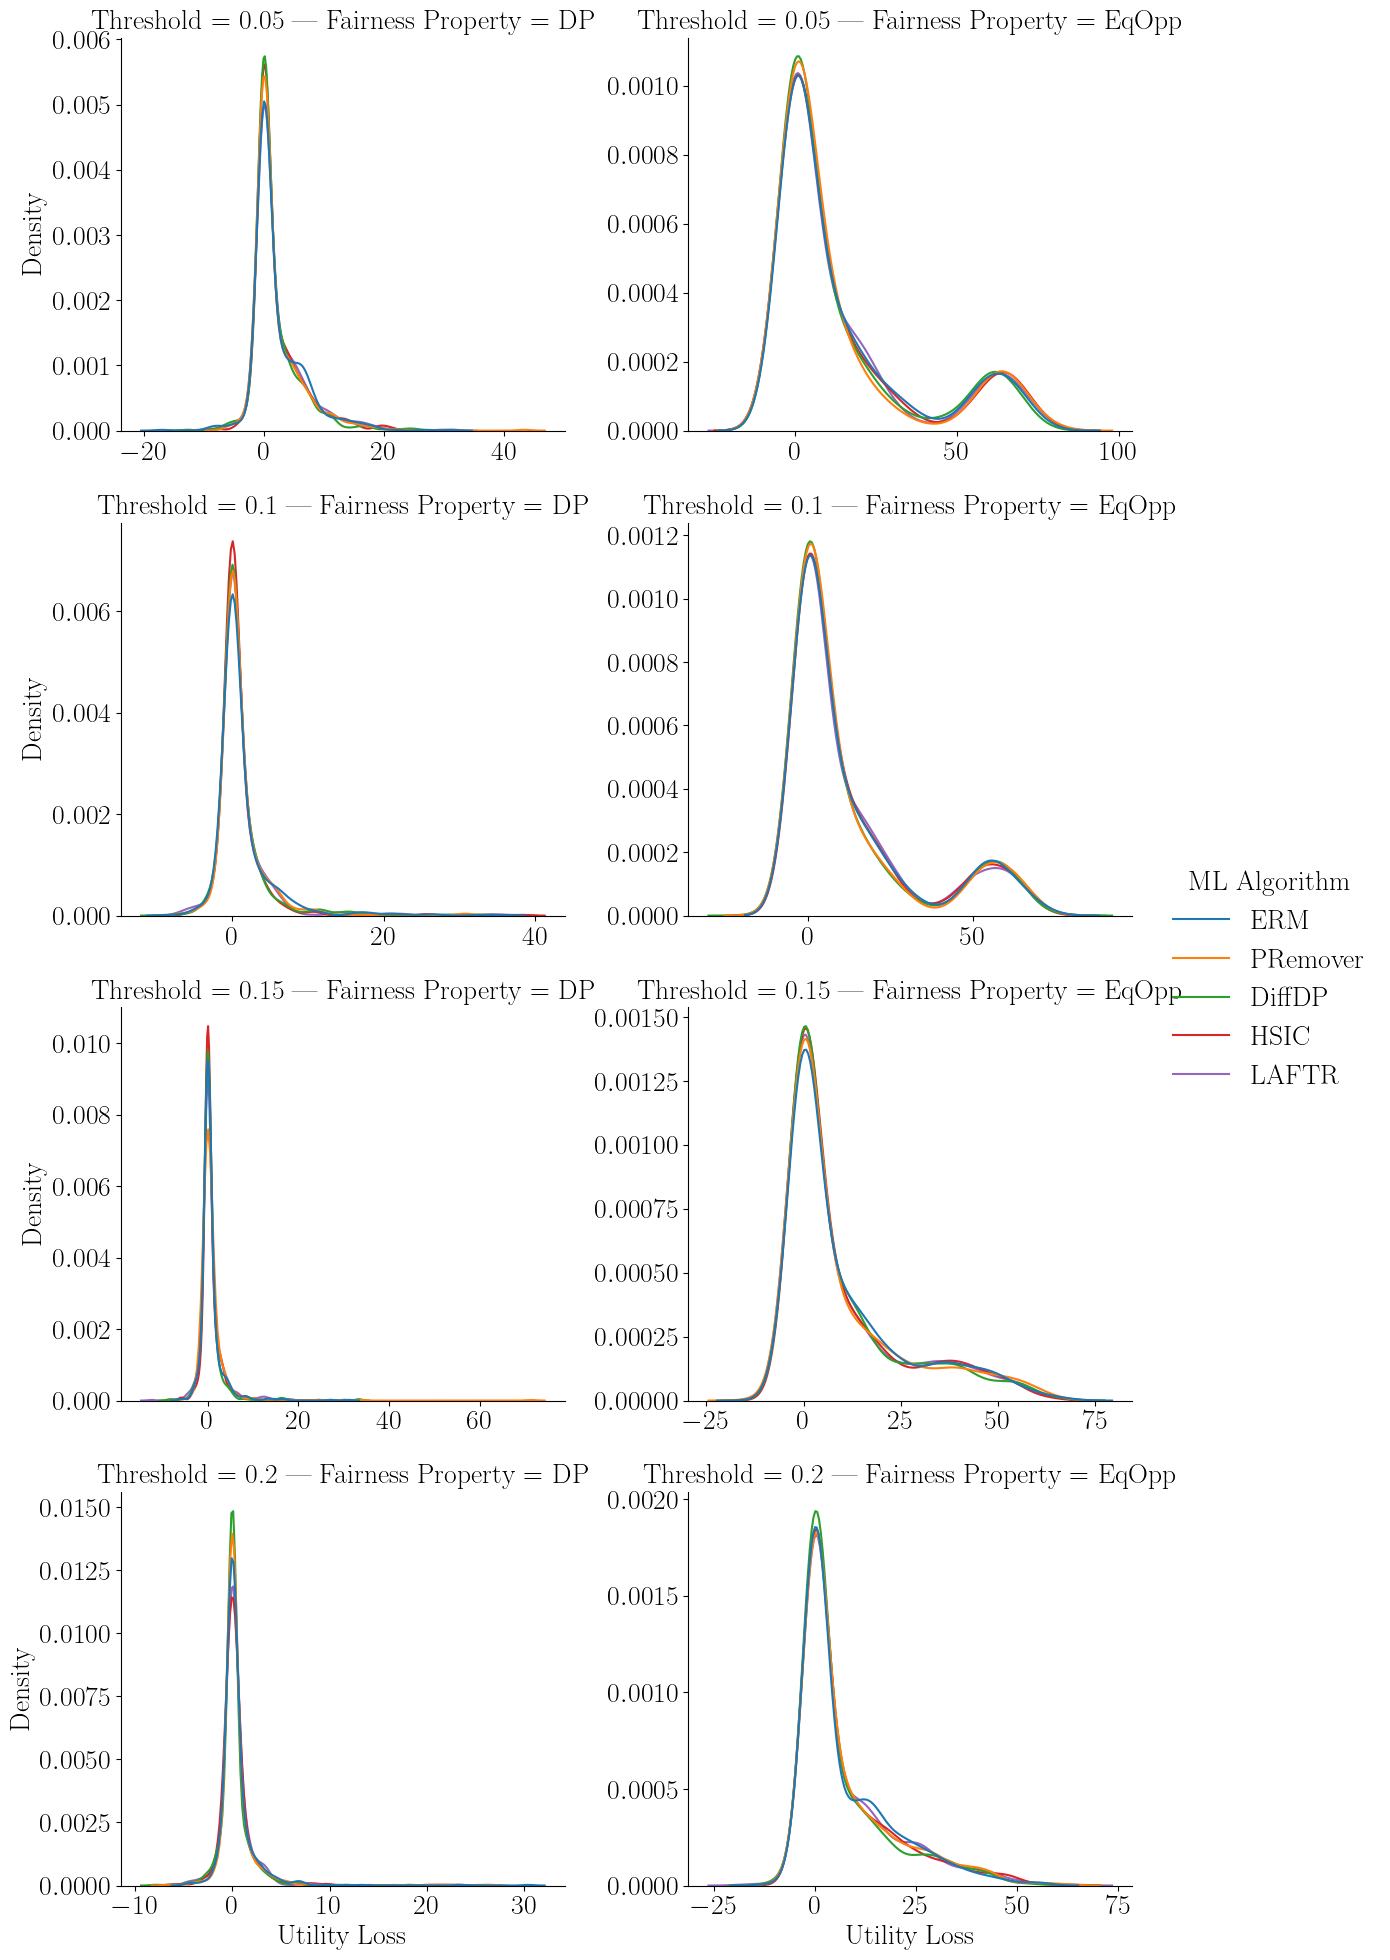

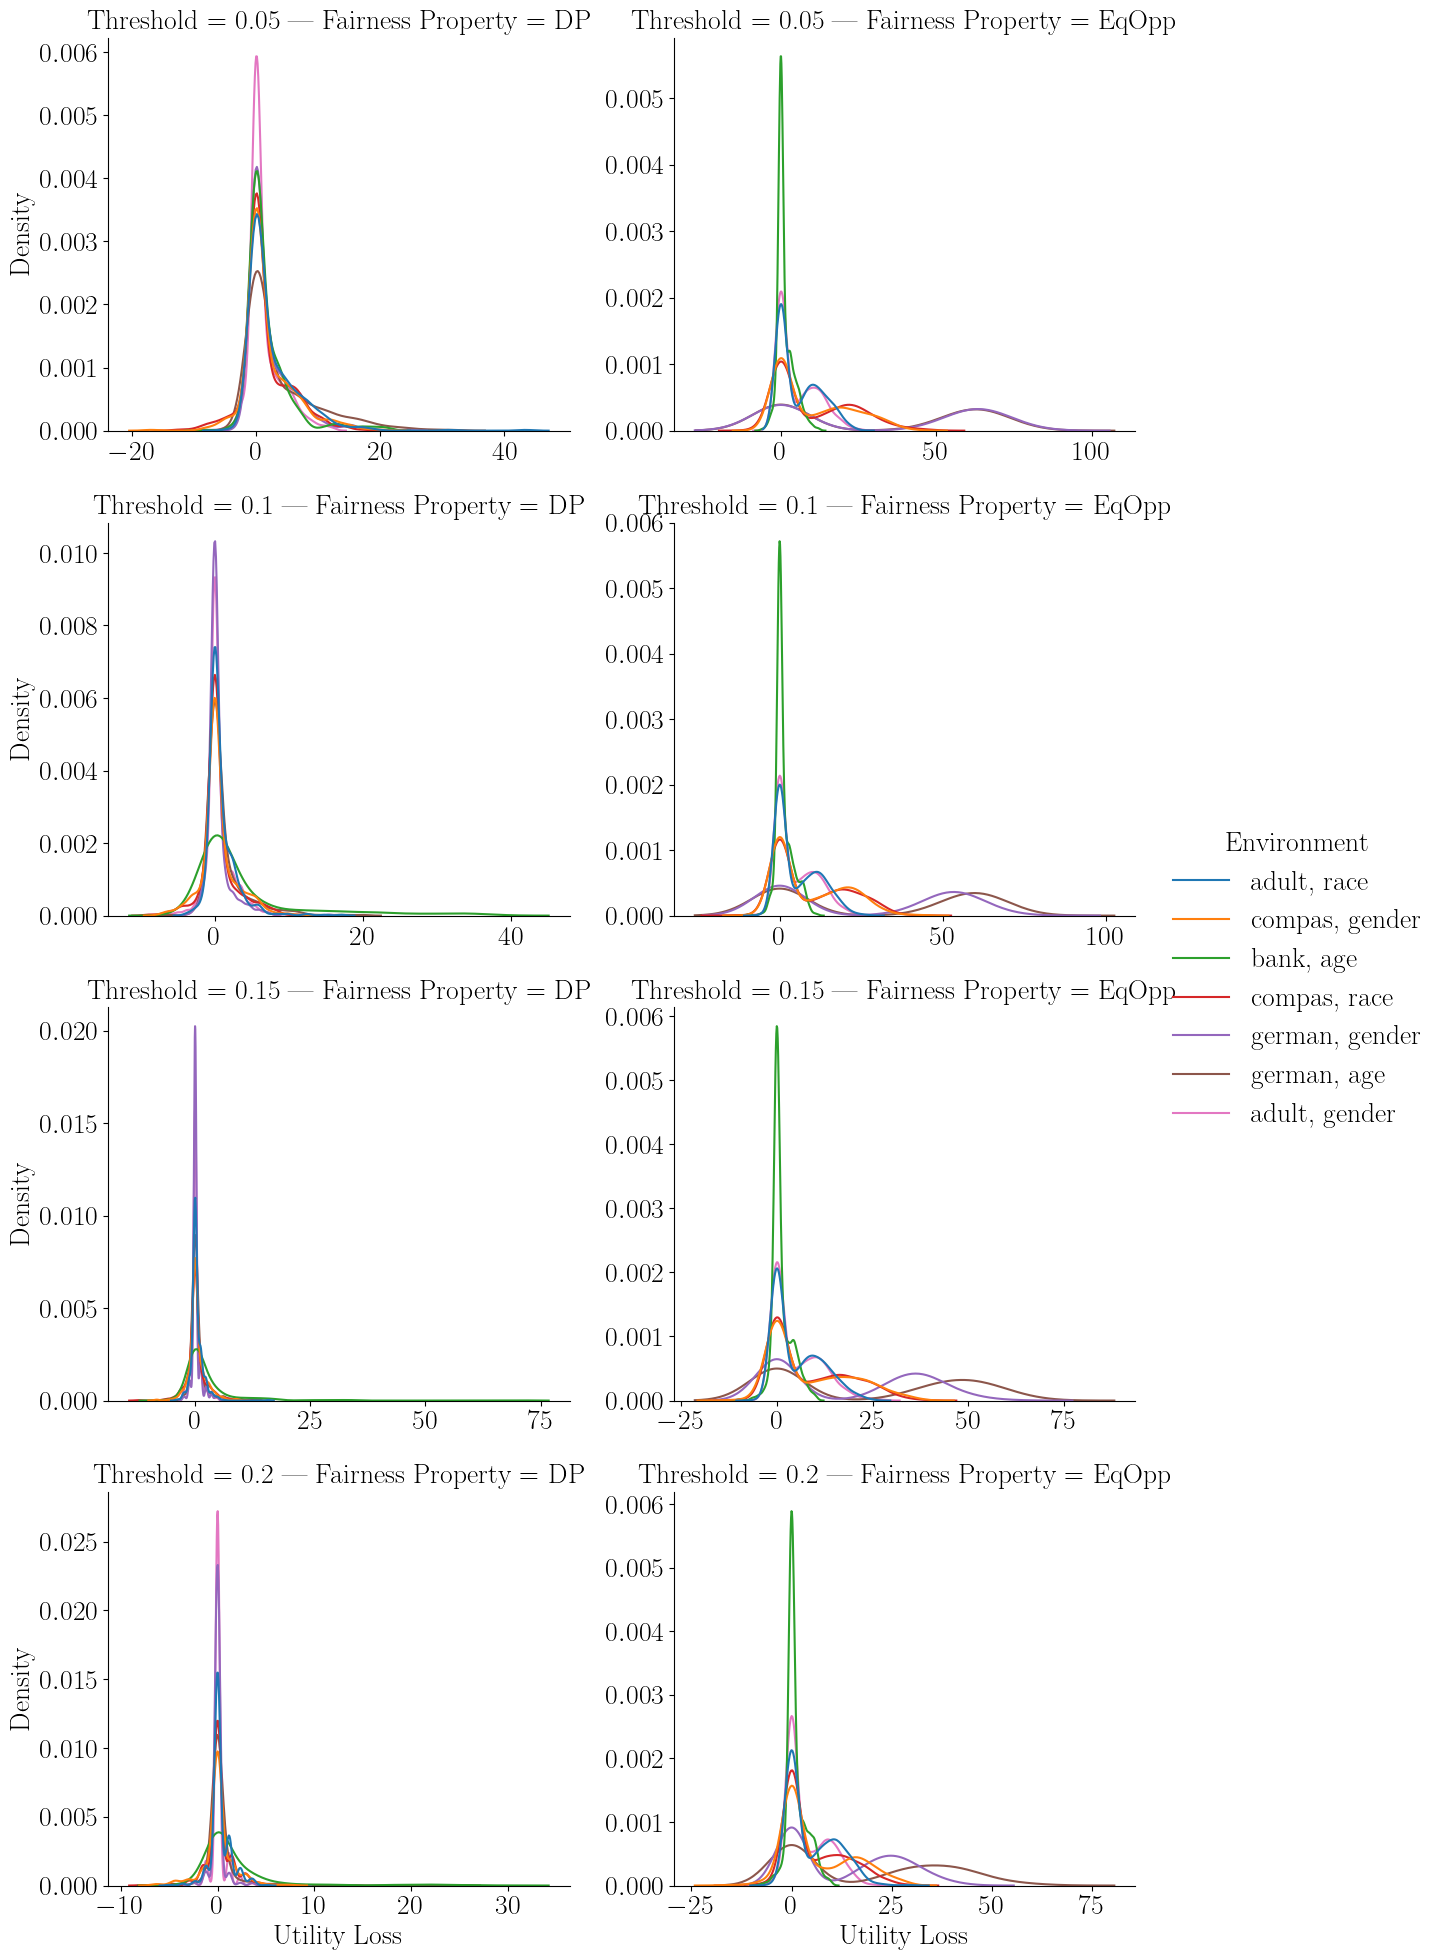

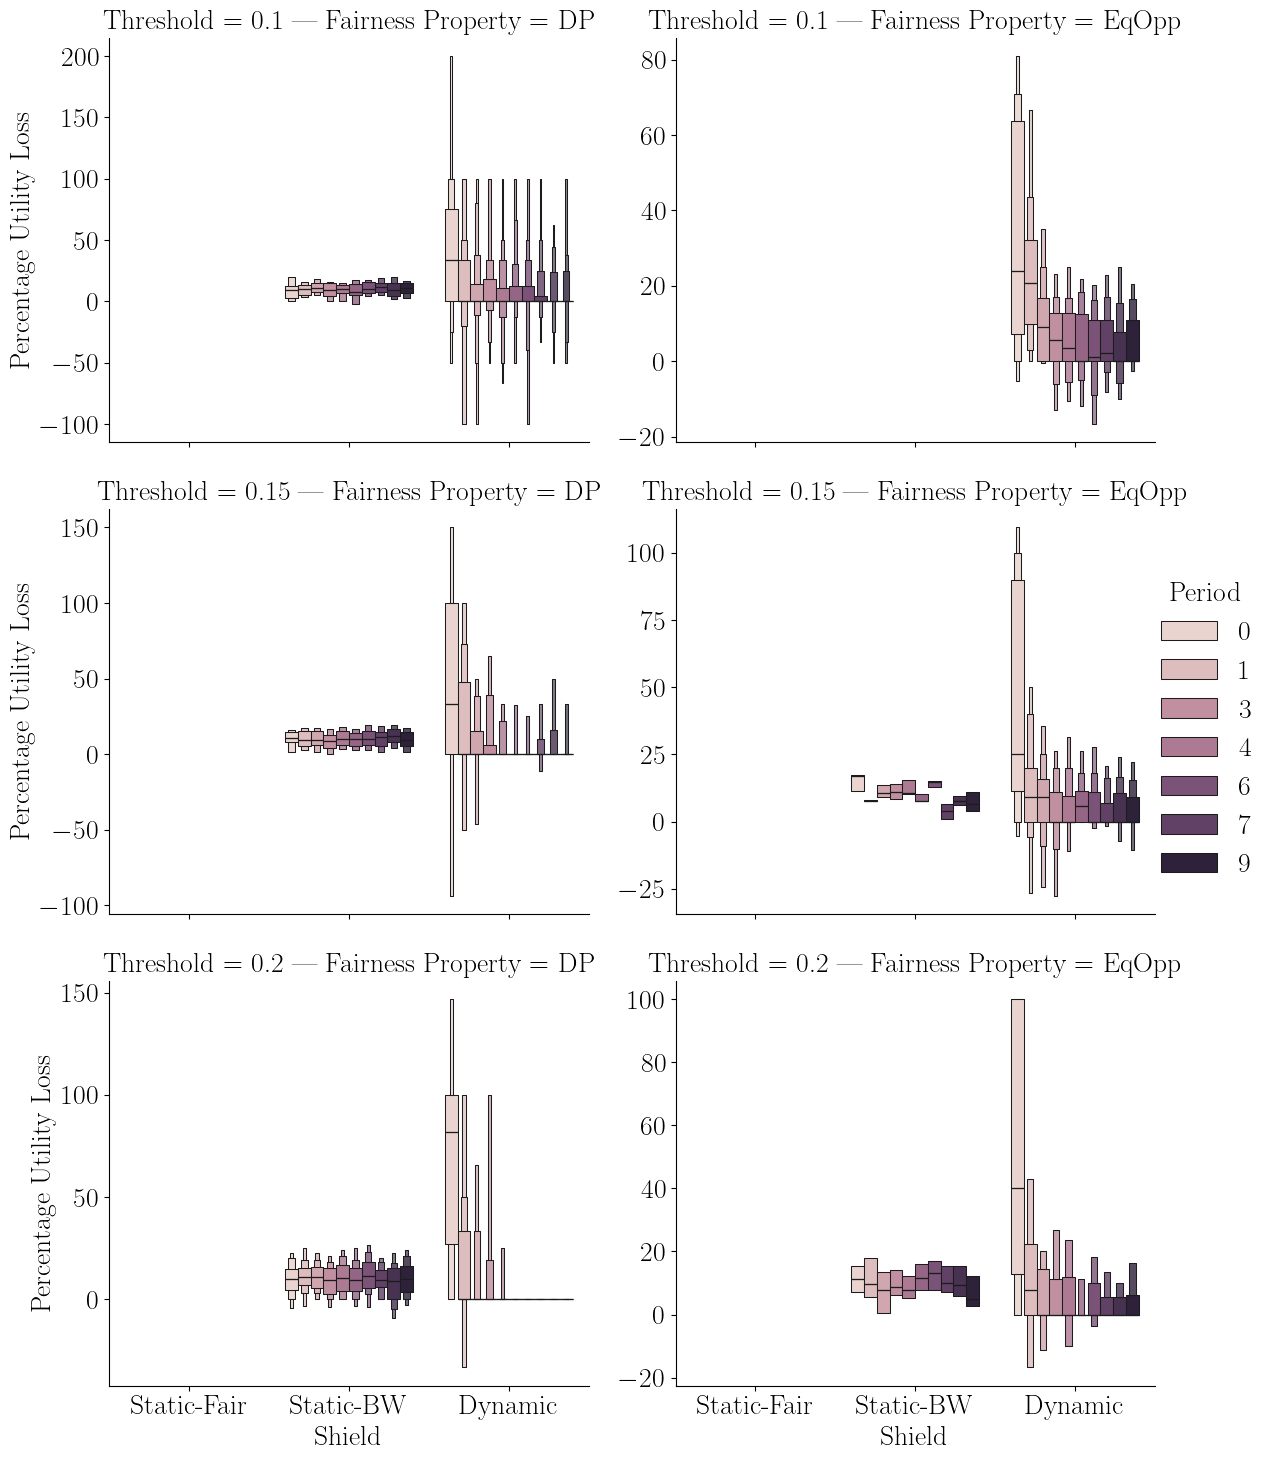

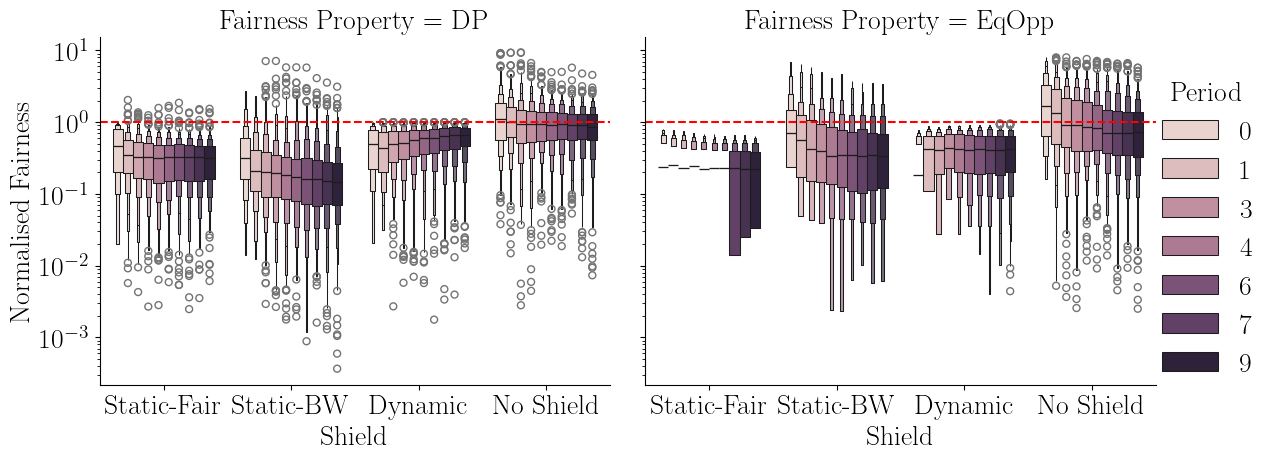

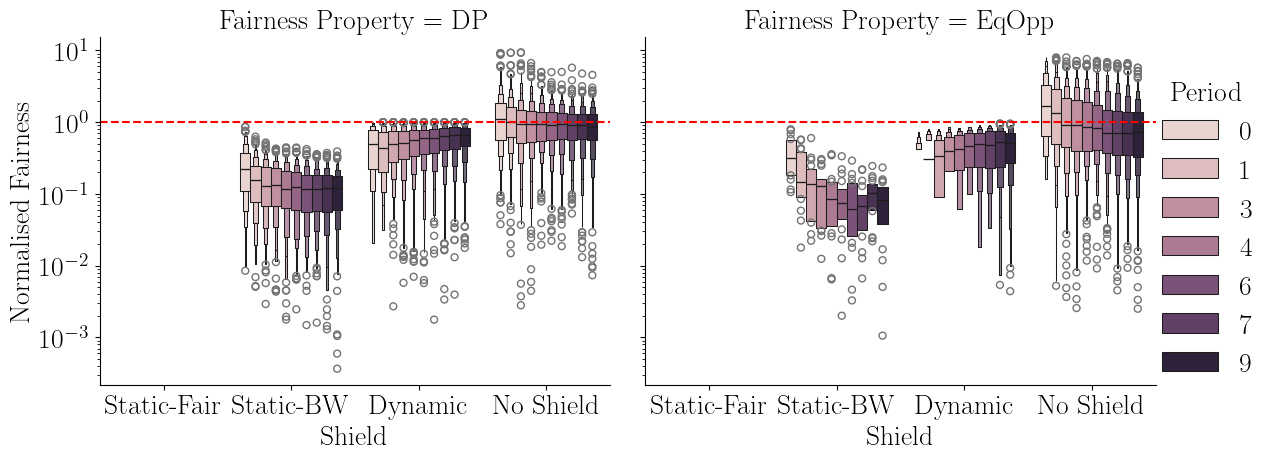

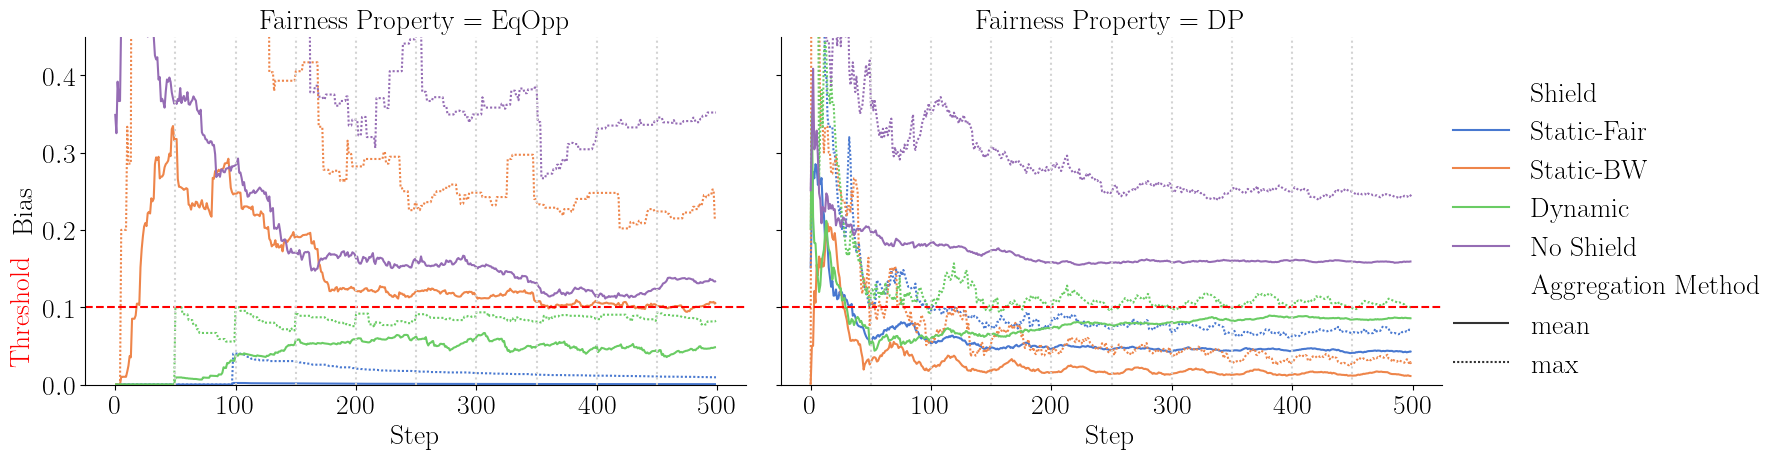

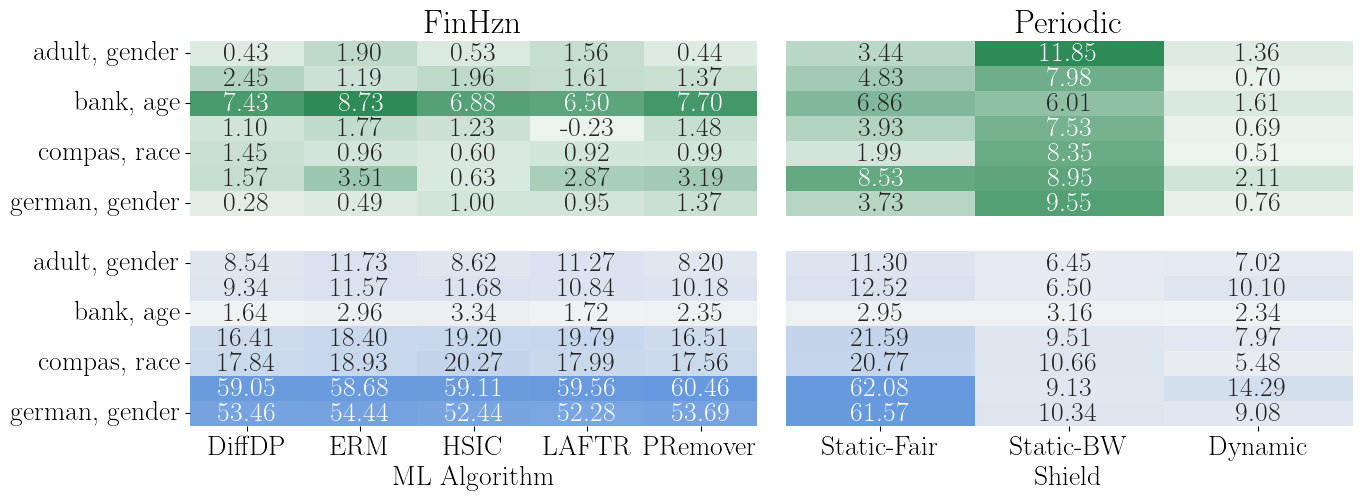

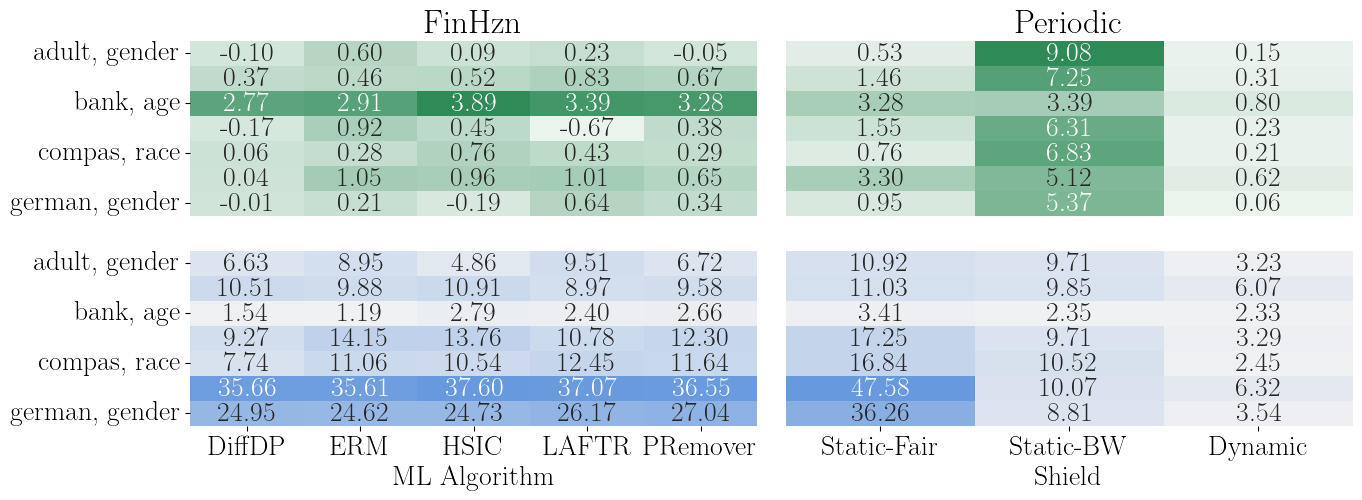

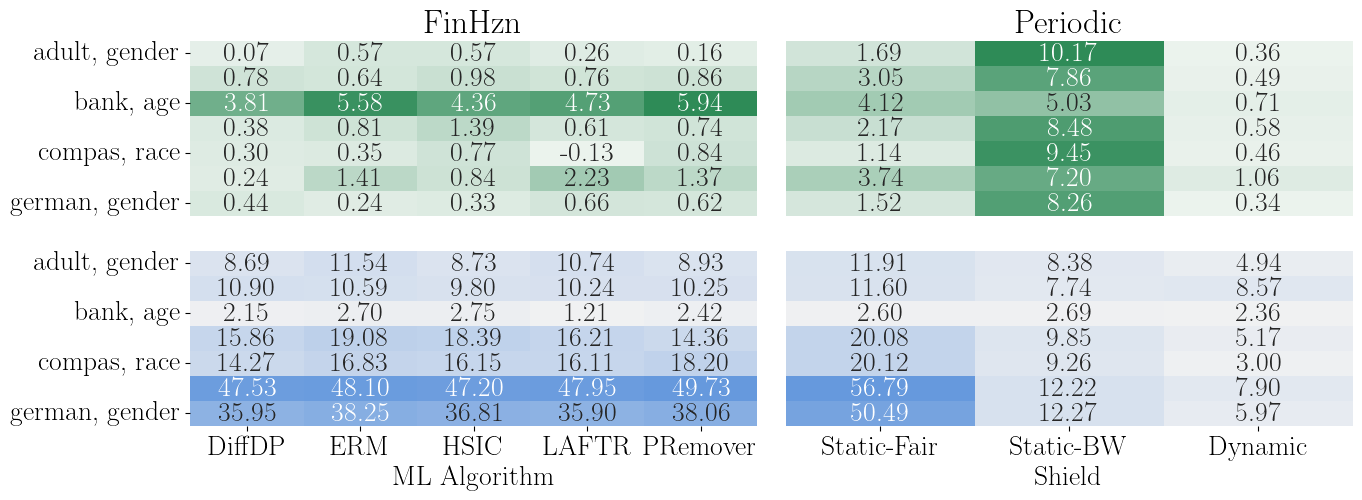

In [37]:
reproduce_experiments()